In [354]:
import os
from graspy.simulations import sbm
from graspy.plot import heatmap, pairplot
from graspy.embed import AdjacencySpectralEmbed, select_dimension, selectSVD
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import FastICA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from src.cluster import BinaryCluster
import pandas as pd
from collections import Counter
import seaborn as sns
import pandas as pd

sns.set_style("white")

In [2]:
from pathlib import Path
def savefig(
    name,
    fmt="png",
    dpi=300,
    foldername=None,
    subfoldername="outs",
    pathname="/Users/TingshanLiu/Desktop/2020 summer/TL_maggot",
    bbox_inches="tight",
    pad_inches=0.5,
    save_on=True,
    transparent=False,
    **kws,
):
    if save_on:
        path = _handle_dirs(pathname, foldername, subfoldername)
        savename = path / str(name + "." + fmt)
        plt.savefig(
            savename,
            format=fmt,
            facecolor="white",
            transparent=transparent,
            bbox_inches=bbox_inches,
            pad_inches=pad_inches,
            dpi=dpi,
            **kws,
        )
        print(f"Saved figure to {savename}")

def _handle_dirs(pathname, foldername, subfoldername):
    path = Path(pathname)
    if foldername is not None:
        path = path / foldername
        if not os.path.isdir(path):
            os.mkdir(path)
        if subfoldername is not None:
            path = path / subfoldername
            if not os.path.isdir(path):
                os.mkdir(path)
    return path

def savecsv(
    df,
    name,
    foldername=None,
    subfoldername="csvs",
    pathname="/Users/TingshanLiu/Desktop/2020 summer/TL_maggot",
    save_on=True,
):
    if save_on:
        path = _handle_dirs(pathname, foldername, subfoldername)
        savename = path / str(name + ".csv")
        df.to_csv(savename)
        print(f"Saved DataFrame to {savename}")



FNAME = os.path.basename('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_repo/maggot_models')

def stashfig(name, **kws):
    savefig(name, foldername = FNAME, save_on = True, **kws)
    
def stashcsv(df, name, **kws):
    savecsv(df, name, foldername=FNAME, **kws)

In [35]:
def undirect_p_2paths(ncluster, path1, path2, path1prob, path2prob):
    p1 = np.zeros([ncluster, ncluster])
    p2 = np.zeros([ncluster, ncluster])
    for i in range(len(path1)-1):
        p1[path1[i], path1[i+1]] = path1prob
        p1[path1[i+1], path1[i]] = path1prob
    for i in range(len(path2)-1):
        p2[path2[i], path2[i+1]] = path2prob
        p2[path2[i+1], path2[i]] = path2prob
    for i in range(ncluster):
        for j in range(i,ncluster):
            if i == j:
                p1[i,j] = 0.8
                p2[i,j] = 0.8
            elif p1[i,j] == 0:
                p1[i,j] = 0.1
                p1[j,i] = p1[i,j]
    for i in range(ncluster):
        for j in range(i,ncluster):
            if p2[i,j] == 0:
                p2[i,j] = 0.1
                p2[j,i] = p2[i,j]
    p = (p1 + p2) / 2
    return p, p1, p2



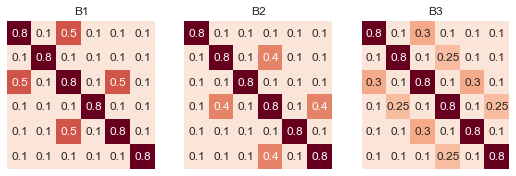

In [391]:
ncluster = 6
p,p1,p2 = undirect_p_2paths(6, [0,2,4],[1,3,5],0.5,0.4)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(9,3))
for i,j,k in zip([p1,p2,p], [ax1,ax2,ax3], ["B1","B2","B3"]):
    sns.heatmap(i, annot= True, cbar=False, xticklabels="", yticklabels="", square = True, cmap = 'RdBu_r', center=0, ax = j)
    j.set_title(k)


In [252]:
def df_embed(embed):
    df = pd.DataFrame(embed)
    df["block"] = 0
    df["path"] = 0
    for i in range(ncluster):
        df["block"].iloc[i*size:(i+1)*size] = i+1
        if i in [0,2,4]:
            df["path"].iloc[i*size:(i+1)*size] = 1 
        elif i in [1,3,5]:
            df["path"].iloc[i*size:(i+1)*size] = 2

    return df

In [281]:
def true_label(ncluster, size):
    label_true = []
    for i in range(ncluster):
        label_true = np.concatenate((label_true, np.ones(size)+i))
    return label_true

def ARI(labels):
    score = adjusted_rand_score(label_true, labels)

    return score

In [300]:
def Kmean_cluster(size, ite):
    score_ase = np.zeros(ite); score_ica = np.zeros(ite); score_nmf = np.zeros(ite)
    score = np.zeros((3,2))
    n = np.repeat(size, ncluster)
    for i in range(ite):
        G = sbm(n= n, p= p) 
        ase = AdjacencySpectralEmbed(n_components= d)
        embed_ase = ase.fit_transform(G)
        score_ase[i] = ARI(KMeans(n_clusters= ncluster).fit(embed_ase).labels_)
        ica = FastICA(algorithm = "parallel", max_iter=1000, n_components= d)
        embed_ica = ica.fit_transform(G)
        score_ica[i] = ARI(KMeans(n_clusters= ncluster).fit(embed_ica).labels_)
        #nmf = NMF(n_components= d)
        #embed_nmf = nmf.fit_transform(G)
        #score_nmf[i] = ARI(KMeans(n_clusters= ncluster).fit(embed_nmf).labels_)
    method = [score_ase, score_ica]
    for i in range(len(method)):
        score[i,0] = np.mean(method[i]); score[i,1] = np.std(method[i])
    return score


In [317]:
ncluster = 6
d = 2
ite = 50
sizes = np.arange(50,500,50)
score = np.zeros((len(sizes),3,2))
for i in range(len(sizes)):
    label_true = true_label(ncluster, sizes[i])
    score_500[i] = Kmean_cluster(sizes[i], ite)


Saved figure to /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_models/outs/SBM-ICA-ASE-ARIvN.png


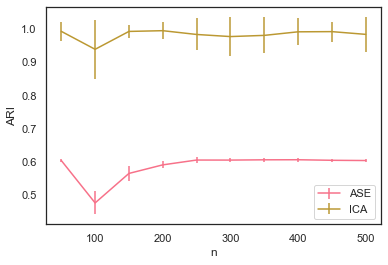

In [340]:
# plot clusterings
fig, ax = plt.subplots(1)
fig1 = plt.errorbar(np.arange(50,550,50), score[:,0,0], yerr= score[:,0,1])
fig2 = plt.errorbar(np.arange(50,550,50), score[:,1,0], yerr= score[:,1,1])
plt.legend((fig1, fig2), ("ASE","ICA"))
ax.set_xlabel("n")
ax.set_ylabel("ARI")

#stashfig("SBM-ICA-ASE-ARIvN")

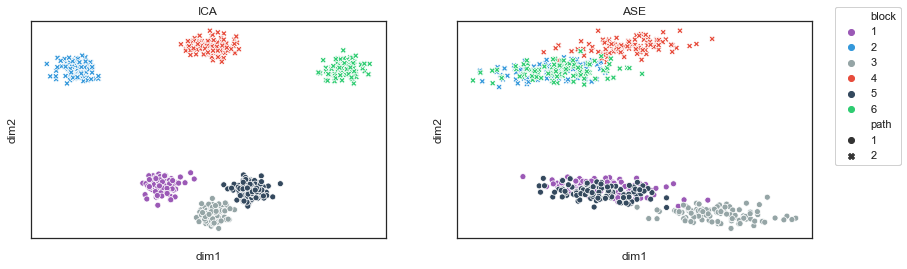

In [390]:
# plot embeddings

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,4))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig1 = sns.scatterplot(data = df_embed(embed_ica), x = 0, y = 1, hue = "block", style = "path", ax = ax1, legend='full', palette=flatui)
fig2 = sns.scatterplot(data = df_embed(embed_ase), x = 0, y = 1, hue = "block", style = "path", ax = ax2, legend='full', palette=flatui)
fig1.set(xticklabels=[], yticklabels=[], xlabel = "dim1", ylabel = "dim2", title = "ICA")
fig2.set(xticklabels=[], yticklabels=[], xlabel = "dim1", ylabel = "dim2", title = "ASE")
fig1.legend(loc='center left', bbox_to_anchor=(2.25, 0.7), ncol=1)
fig2.legend(loc='center left', bbox_to_anchor=(1.05, 0.7), ncol=1)

#stashfig("SBM-ICA-ASE-embed2paths-n=100")